link for this kaggle kernel : https://www.kaggle.com/nadergo/english-to-arabic-with-a-pytorch-transformer

for this notebook we will build a pytorch transformer to translate english sentences into arabic,
main limitation here is lack of publicly available data

I will be using torchtext it's really good for preparing the data, it has a good documentation also those are links about an example using torchtext and a tutorial

https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

to understand how the transformer works, I recommend these videos 

https://www.youtube.com/watch?v=U0s0f995w14&t=2522s

https://www.youtube.com/watch?v=M6adRGJe5cQ&t=1781s

In [1]:
"""
torch modules
with ofc  numpy  and pandas

"""

import pandas as pd
import numpy as np 

from torch import nn
import torch
from torchtext import data
from torch.nn  import functional as F
import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 

  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)

gpu up


In [2]:
import random
SEED= 32

In [3]:
"""
regex and the tokenizers
"""

import re
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.ar import Arabic
from nltk.translate.bleu_score import sentence_bleu

enNLP = English()
arNLP = Arabic()

enTokenizer = Tokenizer(enNLP.vocab)
arTokenizer =  Tokenizer(arNLP.vocab)




In [4]:
df = pd.read_csv("/kaggle/input/arabic-to-english-translation-sentences/ara_eng.txt",delimiter="\t",names=["eng","ar"])

In [5]:
df

,eng,ar
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
...,...,...
24633,rising voices promoting a more linguistically ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,following last year s successful campaign we i...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,during last year s challenge we also met langu...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,to take part just follow the simple steps outl...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


In [6]:
"""
defining the tokenizers for arabic and english  

creating the fields for the dataset from torchtext 
that class is the simple way I could find for turning a df into a torch dataset

نهها and ببدأ are just arbitrary words for init and end of sentence tokens  
for some reason when I choose an arabic word for the unknown token  the vocab doesn't replace words that are not in the vocab  
"""

def myTokenizerEN(x):
 return  [word.text for word in 
          enTokenizer(re.sub(r"\s+\s+"," ",re.sub(r"[\.\'\`\"\r+\n+]"," ",x.lower())).strip())]
def myTokenizerAR(x):
 return  [word.text for word in 
          arTokenizer(re.sub(r"\s+\s+"," ",re.sub(r"[\.\'\`\"\r+\n+]"," ",x.lower())).strip())]

SRC = data.Field(tokenize=myTokenizerEN,batch_first=False,init_token="<sos>",eos_token="<eos>")
TARGET = data.Field(tokenize=myTokenizerAR,batch_first=False,tokenizer_language="ar",init_token="ببدأ",eos_token="نهها")

class DataFrameDataset(data.Dataset):

    def __init__(self, df, src_field, target_field, is_test=False, **kwargs):
        fields = [('eng', src_field), ('ar',target_field)]
        examples = []
        for i, row in df.iterrows():
            eng = row.eng 
            ar = row.ar
            examples.append(data.Example.fromlist([eng, ar], fields))

        super().__init__(examples, fields, **kwargs)

        
torchdataset = DataFrameDataset(df,SRC,TARGET)


In [7]:
train_data, valid_data = torchdataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [8]:
SRC.build_vocab(train_data,min_freq=2)
TARGET.build_vocab(train_data,min_freq=2)  

In [9]:


#Commonly used words
print(TARGET.vocab.freqs.most_common(10))  

[('في', 10140), ('من', 8760), ('على', 5248), ('ان', 2553), ('عن', 2310), ('العالمية', 2261), ('الاصوات', 2195), ('الى', 1826), ('هذا', 1619), ('لا', 1595)]


In [10]:

"""
we are using batches for validation and test set because of memory usage we can't pass the whole set at once

try lowering the batch size if you are out of memory 
"""
BATCH_SIZE = 64



train_iterator,valid_iterator = data.BucketIterator.splits(
    (train_data,valid_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort=False,
    sort_within_batch=False,
shuffle=True)

In [11]:
"""
to point out one thing about the transformer what it could do is to enable 
training on the whole sequence at once but on really using it for translation it predicts the next word 
then it feeds the prediction into the sequence again until the model predict <eos> token (with a max length ofc)

"""
class TranslateTransformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        max_len,
    ):
        super(TranslateTransformer, self).__init__()
        self.srcEmbeddings = nn.Embedding(src_vocab_size,embedding_size)
        self.trgEmbeddings= nn.Embedding(trg_vocab_size,embedding_size)
        self.srcPositionalEmbeddings= nn.Embedding(max_len,embedding_size)
        self.trgPositionalEmbeddings= nn.Embedding(max_len,embedding_size)
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.src_pad_idx = src_pad_idx
        self.max_len = max_len
    
    def make_src_mask(self, src):
        src_mask = src.transpose(0,1) == self.src_pad_idx

        return src_mask.to(device)

    def forward(self,x,trg):
        src_seq_length = x.shape[0]
        N = x.shape[1]
        trg_seq_length = trg.shape[0]
        #adding zeros is an easy way
        src_positions = (
            torch.arange(0, src_seq_length)
            .reshape(src_seq_length,1)  + torch.zeros(src_seq_length,N) 
        ).to(device)
        
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .reshape(trg_seq_length,1)  + torch.zeros(trg_seq_length,N) 
        ).to(device)


        srcWords = self.dropout(self.srcEmbeddings(x.long()) +self.srcPositionalEmbeddings(src_positions.long()))
        trgWords = self.dropout(self.trgEmbeddings(trg.long())+self.trgPositionalEmbeddings(trg_positions.long()))
        
        src_padding_mask = self.make_src_mask(x)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(device)
        
        
        out = self.transformer(srcWords,trgWords, src_key_padding_mask=src_padding_mask,tgt_mask=trg_mask )
        out= self.fc_out(out)
        return out
        



In [12]:
#No. of unique tokens in text
src_vocab_size  = len(SRC.vocab)
print("Size of english vocabulary:",src_vocab_size)

#No. of unique tokens in label
trg_vocab_size =len(TARGET.vocab)
print("Size of arabic vocabulary:",trg_vocab_size)

num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3

max_len= 227
embedding_size= 256
src_pad_idx =SRC.vocab.stoi["<pad>"]


model = TranslateTransformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    max_len
).to(device)

Size of english vocabulary: 12886
Size of arabic vocabulary: 22069


In [13]:
loss_track = []
loss_validation_track= []

In [46]:
"""
I'm using adagrad because it assigns bigger updates to less frequently updated weights so 
so thought it could be useful for words not used a lot 
"""

optimizer = optim.Adagrad(model.parameters(),lr = 0.003)
EPOCHS = 60


pad_idx = SRC.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx) 

for i in range(50,EPOCHS):
    stepLoss=[]
    model.train() # the training mode for the model (applies dropout and batchnorms)
    for batch  in train_iterator:
        input_sentence = batch.eng.to(device)
        trg = batch.ar.to(device)

        optimizer.zero_grad()
        out = model(input_sentence,trg[:-1])
        out = out.reshape(-1,trg_vocab_size)
        trg = trg[1:].reshape(-1)
        loss = criterion(out,trg)
        
        
        loss.backward()
        optimizer.step()
        stepLoss.append(loss.item())
        

    loss_track.append(np.mean(stepLoss))
    print("train crossentropy at epoch {} loss: ".format(i),np.mean(stepLoss))
    
    stepValidLoss=[]
    model.eval() # the evaluation mode for the model (doesn't apply dropout and batchNorm)
    for batch  in valid_iterator:
        input_sentence = batch.eng.to(device)
        trg = batch.ar.to(device)

        optimizer.zero_grad()
        out = model(input_sentence,trg[:-1])
        out = out.reshape(-1,trg_vocab_size)
        trg = trg[1:].reshape(-1)
        loss = criterion(out,trg)
        
        stepValidLoss.append(loss.item())
  
    loss_validation_track.append(np.mean(stepValidLoss))
    print("validation crossentropy at epoch {} loss: ".format(i),np.mean(stepValidLoss))
    
    
        

train crossentropy at epoch 50 loss:  5.515523125598957
validation crossentropy at epoch 50 loss:  5.83651504888163
train crossentropy at epoch 51 loss:  4.316616508867834
validation crossentropy at epoch 51 loss:  5.815157500180331
train crossentropy at epoch 52 loss:  4.106851389655819
validation crossentropy at epoch 52 loss:  5.802550842235615
train crossentropy at epoch 53 loss:  3.9637860090701613
validation crossentropy at epoch 53 loss:  5.830171894717526
train crossentropy at epoch 54 loss:  3.8444339896177318
validation crossentropy at epoch 54 loss:  5.815997786336131
train crossentropy at epoch 55 loss:  3.744735551344884
validation crossentropy at epoch 55 loss:  5.84185047273512
train crossentropy at epoch 56 loss:  3.653116785860681
validation crossentropy at epoch 56 loss:  5.855011853304776
train crossentropy at epoch 57 loss:  3.5713957331397315
validation crossentropy at epoch 57 loss:  5.859390438377083
train crossentropy at epoch 58 loss:  3.494734538840009
validat

I tried doing more than 60 epochs but it turned into copying and pasting the training examples 

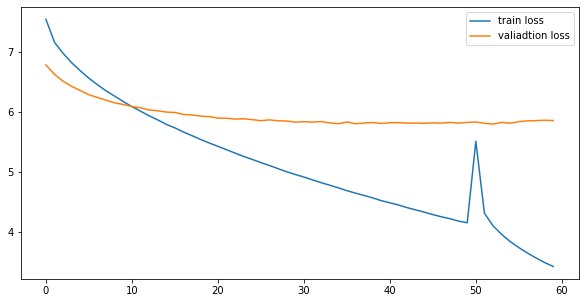

In [48]:
import matplotlib.pyplot as plt 

#the train loss after 50 epoch
plt.figure(figsize=(10,5))
plt.plot(range(60),loss_track,label="train loss")
plt.plot(range(60),loss_validation_track,label="valiadtion loss")
plt.legend()
plt.show()

In [49]:
"""
this function takes some arguments and returns the translated arabic sentence 

"""

def translate(model,sentence,srcField,targetField,srcTokenizer):
    model.eval()
    processed_sentence = srcField.process([srcTokenizer(sentence)]).to(device)
    trg = ["ببدأ"]
    for _ in range(60):
        
        trg_indecies = [targetField.vocab.stoi[word] for word in trg]
        outputs = torch.Tensor(trg_indecies).unsqueeze(1).to(device)
        outputs = model(processed_sentence,outputs)
        
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<unk>":
            continue 
        trg.append(targetField.vocab.itos[outputs.argmax(2)[-1:].item()])
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "نهها":
            break
    return " ".join([word for word in trg if word != "<unk>"][1:-1])
    
    

In [50]:
translate(model,"I'm happy" ,SRC,TARGET,myTokenizerEN)

'أنا سعيد'

In [51]:
translate(model,"what do you want" ,SRC,TARGET,myTokenizerEN) 

'ماذا تريد أن أفعل؟'

In [52]:
translate(model,"what do you like to have " ,SRC,TARGET,myTokenizerEN) 

'ماذا تريد أن تأكل؟'

In [66]:
translate(model,"I am going outside" ,SRC,TARGET,myTokenizerEN) 

'أنا ذاهب'

In [86]:
translate(model,"he is here" ,SRC,TARGET,myTokenizerEN) 

'إنه هنا'

In [87]:
translate(model,"he is not here" ,SRC,TARGET,myTokenizerEN) 

'إنه ليس هنا'

In [55]:
translate(model,"I need help" ,SRC,TARGET,myTokenizerEN)

'أحتاج إلى مساعدتك'

In [154]:
translate(model,"I'm not at home" ,SRC,TARGET,myTokenizerEN)  # it totally get negation right 


'لست في البيت'

In [58]:
translate(model,"I'm ready" ,SRC,TARGET,myTokenizerEN)


'أنا مستعد'

In [69]:
print(translate(model,"it's not important" ,SRC,TARGET,myTokenizerEN) )

ليس مهماً


In [85]:
"""
and the model also can't handle any slightly complicated sentences 
"""
translate(model,"he apologized for the mistake he did" ,SRC,TARGET,myTokenizerEN)

''

as the model doesn't have a significant performance, I think it needs more epochs and much more data (maybe it needs to be bigger also but we have limited ram ) 